## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## Import packages

In [1]:
#importing some useful packages
import cv2
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

%matplotlib inline


Bellow are some helper functions:

In [18]:
def display(images, is_gray = 0, columns=4, rows=5):
    fig=plt.figure(figsize=(10, 10))
    for i in range(1, columns*rows + 1): 
        fig.add_subplot(rows, columns, i)
        if is_gray:
            plt.imshow(images[i-1], cmap='gray')
        else:
            plt.imshow(images[i-1])
    plt.show()
    return

def open(dir_name, images_names):
    images = []
    for image_name in images_names:
        image = mpimg.imread(dir_name + "/" + image_name)
        images.append(image)
    return images

# Applies the Grayscale transform
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# It takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = grayscale(img)
    retval, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, camera_matrix, dist_coeffs, None, camera_matrix)
    return undist    

# It draws the given vertices on the image.
def draw_region_of_interest(img, vertices):
    return cv2.polylines(img.copy(),np.int32(np.array([[vertices[0],vertices[1],vertices[2],vertices[3]]])),True,(255,0,0),10)

# It performs a perspective transform on an image
# Note: It is adviced to input an undistorted image
def corners_unwarp(img, src, dst):
    gray = grayscale(img)
    M = cv2.getPerspectiveTransform(src, dst)
    warped_image = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped_image

# It thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    #  Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    
    # Return a binary image of threshold result
    binary_output = np.zeros_like(s_channel)
    binary_output[( thresh[0] < s_channel ) & ( s_channel <= thresh[1] )] = 1
    
    return binary_output
    

def apply_filter(images, action):
    modified_images = list(map(action, images))
    return modified_images

---
## First, we'll compute the camera calibration using chessboard images

It is recommended to use at least 20 images to get a reliable calibration. We use calibration images of a chessboard taken at different angles and distances.

In [19]:
dir_name = "camera_cal"
images_names = [x for x in os.listdir(dir_name + "/") if x.endswith(".jpg")]

# Make a list of calibration images
images = open(dir_name, images_names)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for img in images:
    gray = grayscale(img)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

We obtained the proper points needed for further undistortion. See how it looks:

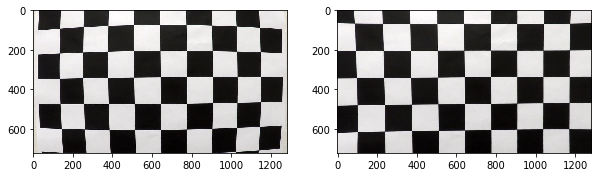

In [20]:
undistorted_image = cal_undistort(images[0], objpoints, imgpoints)
display([images[0], undistorted_image], is_gray = 0, columns=2, rows=1)

# Let's get to our pipeline: 

We will make use of our calibrated camera and continue with the actual road images.

In [21]:
test_dir_name = "test_images"
test_images_names = [x for x in os.listdir(test_dir_name + "/") if x.endswith(".jpg")]

# Make a list of calibration images
test_images = open(test_dir_name, test_images_names)

cal_undistort_action = lambda img: cal_undistort(img, objpoints, imgpoints)    
undistorted_test_images = apply_filter(test_images, cal_undistort_action)

### Perspective transformation

We want to apply a perspective transform because the lane curvature will be easiear to find if it appears like we're looking at it from above (just like a flying bird will do). Even more intuitive, we want to obtain the view of a map.

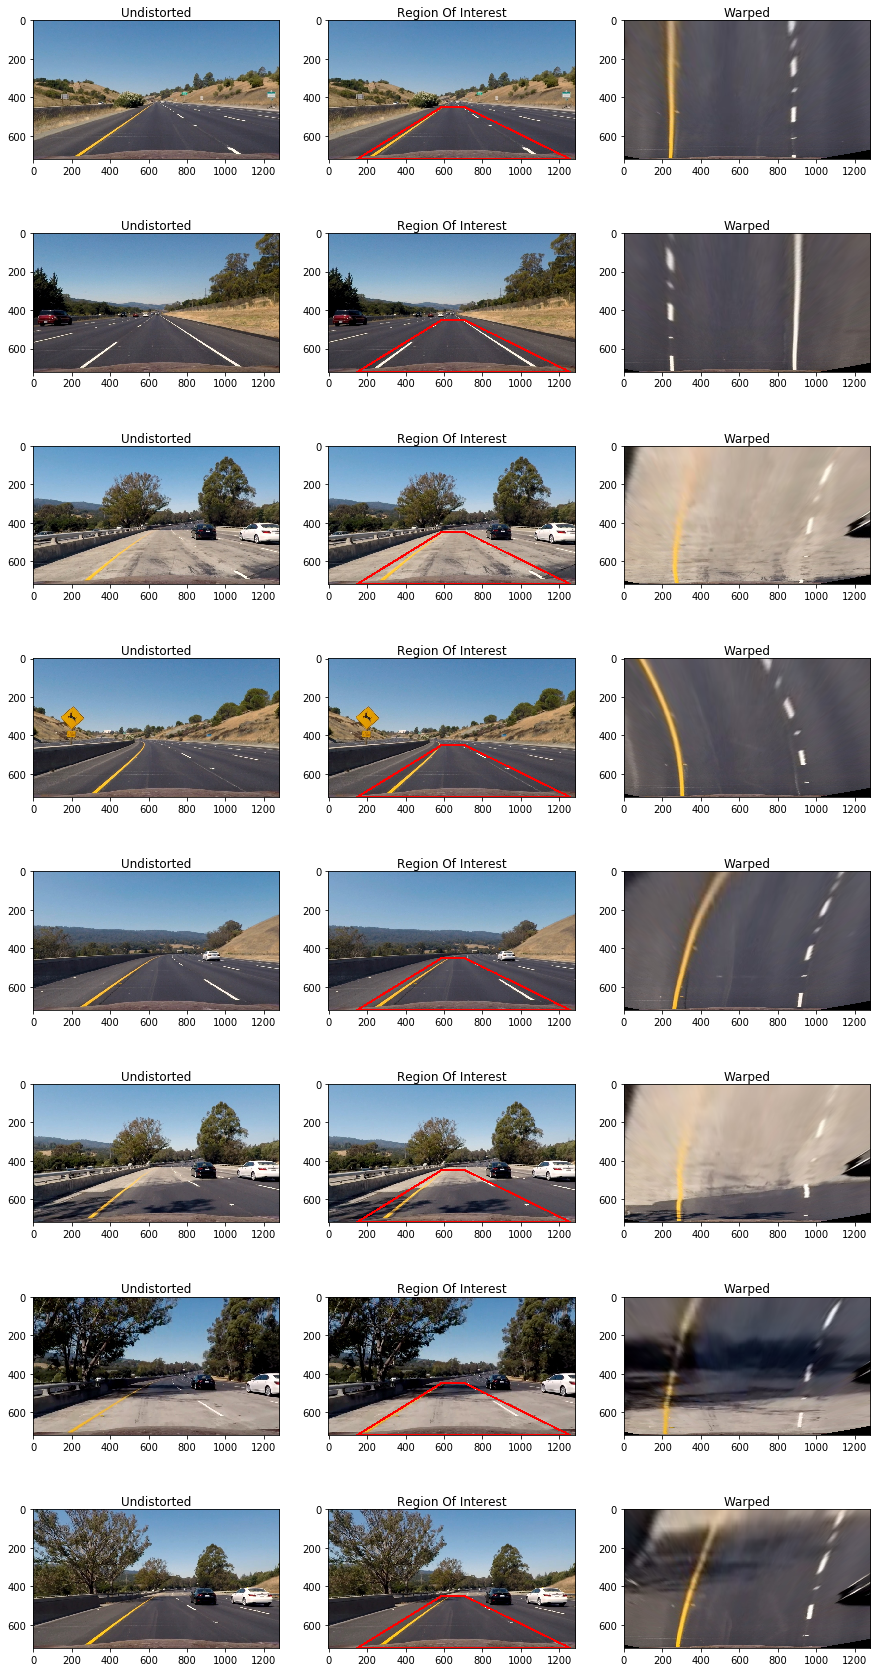

In [25]:
src=np.float32([[150,720],[590,450],[700,450],[1250,720]]) # Source Points for Image Warp
dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]]) # Destination Points for Image Warp

region_of_interest_action = lambda img: draw_region_of_interest(img, src)
marked_images = apply_filter(undistorted_test_images, region_of_interest_action)

unwarp_action = lambda img: corners_unwarp(img, src, dst)
top_down_test_images = apply_filter(undistorted_test_images, unwarp_action)

# Display the different set of images obtained by undistorting,
# drawing the region of interest and changing the perspective 
f, axes= plt.subplots(8,3,figsize=(15,30))
f.subplots_adjust(hspace=0.5)
for i, img in enumerate(top_down_test_images):
    axes[i, 0].set_title("Undistorted")
    axes[i, 0].imshow(undistorted_test_images[i])
    
    axes[i, 1].set_title("Region Of Interest")
    axes[i, 1].imshow(marked_images[i])
    
    axes[i, 2].set_title("Warped")
    axes[i, 2].imshow(top_down_test_images[i])

plt.show()


### Combined S channel and gradient thresholds 

For obtaining as much information as possible from our images, a color space exploration was needed. 

The RGB to grayscale conversion made us loss important color information (such as fading the yellow lane lines). By watching the RGB channels individually we observed that red is the best information keeper between its peers. Still, another problem arised. None of the red, green or blue, behaved good enough in conditions of light changes (which is one of the most common scenarios met in real life). Changing to HSL format helped and we could immediately see that saturation is more consistent for that matter. 

Lanes are vertical lines from our point of view, so we can use gradients to detect only the edges that are more likely to be lanes in the first place. The use of Canny Transformation was a bit too much as it took a derivative with respect to x and y, but for us it is enough to calculate a derivative in the x direction (using the Sobel Operator X). 

In [7]:
def hls_gradient_thresholding(img):

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Grayscale image
    # NOTE: we already now that standard grayscaling lost color information for the lane lines
    gray = grayscale(img)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

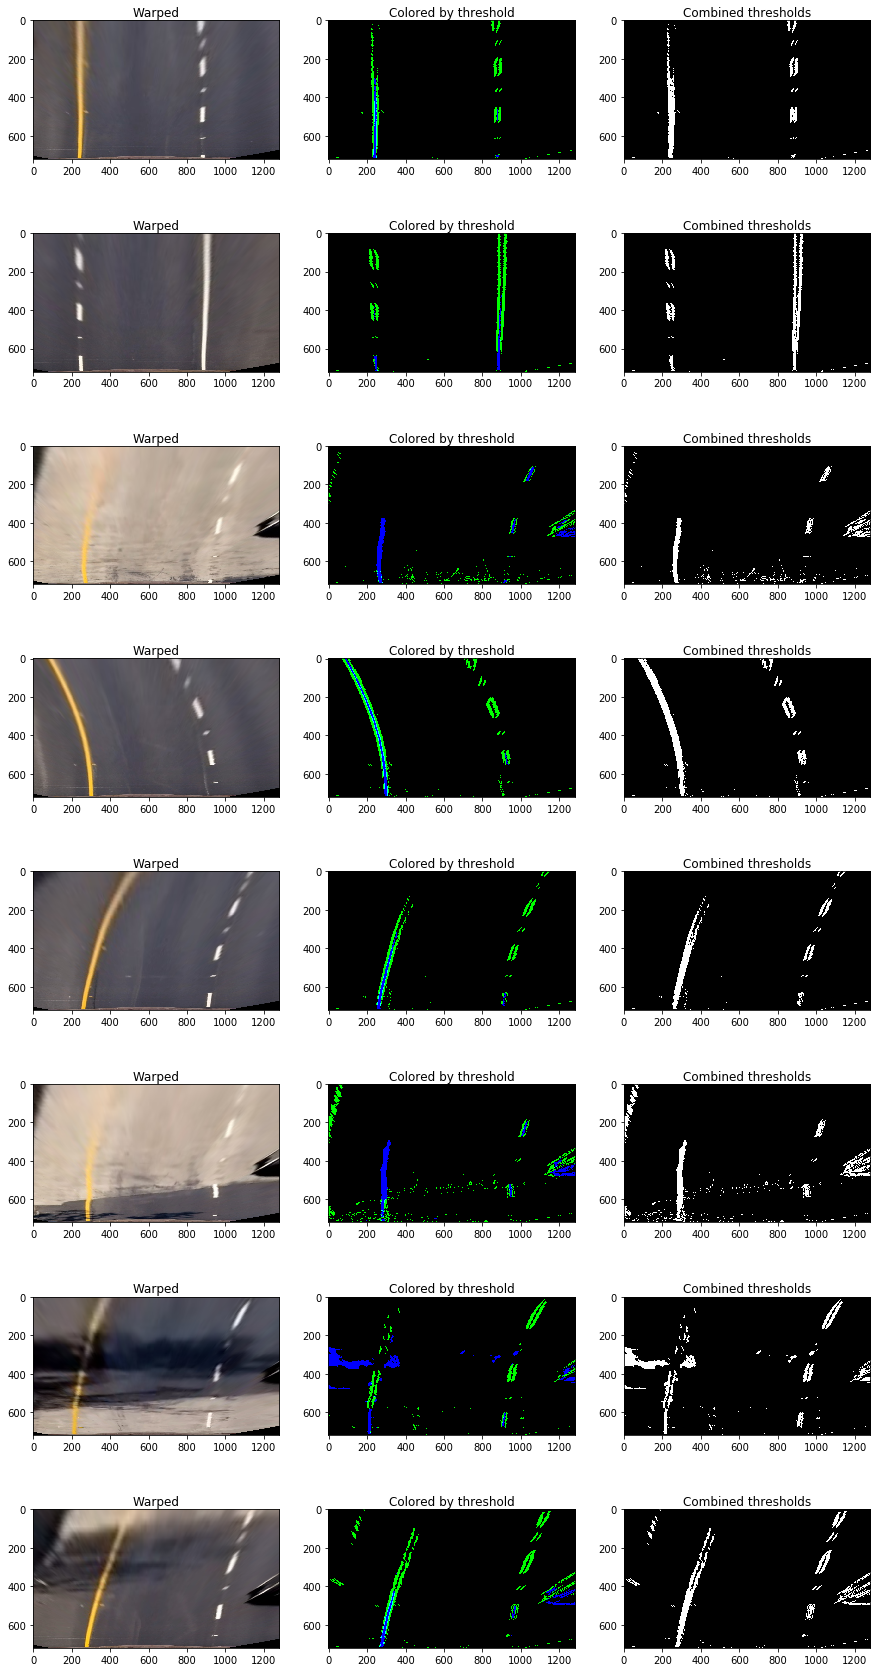

In [8]:
color_binaries = []
combined_binaries = []

# Display the different set of images 

f, axes= plt.subplots(8,3,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for i, img in enumerate(top_down_test_images):
    color_binary, combined_binary=hls_gradient_thresholding(top_down_test_images[i])
    
    axes[i, 0].set_title("Warped")
    axes[i, 0].imshow(top_down_test_images[i])
    
    axes[i, 1].set_title("Colored by threshold")
    axes[i, 1].imshow(color_binary)
    
    axes[i, 2].set_title("Combined thresholds")
    axes[i, 2].imshow(combined_binary, cmap='gray')
    
    color_binaries.append(color_binary)
    combined_binaries.append(combined_binary)
plt.show()


# Finding the lines

## Histogram peaks

Plotting a histogram of where the binary activations occur is a good initial step in finging the lanes.

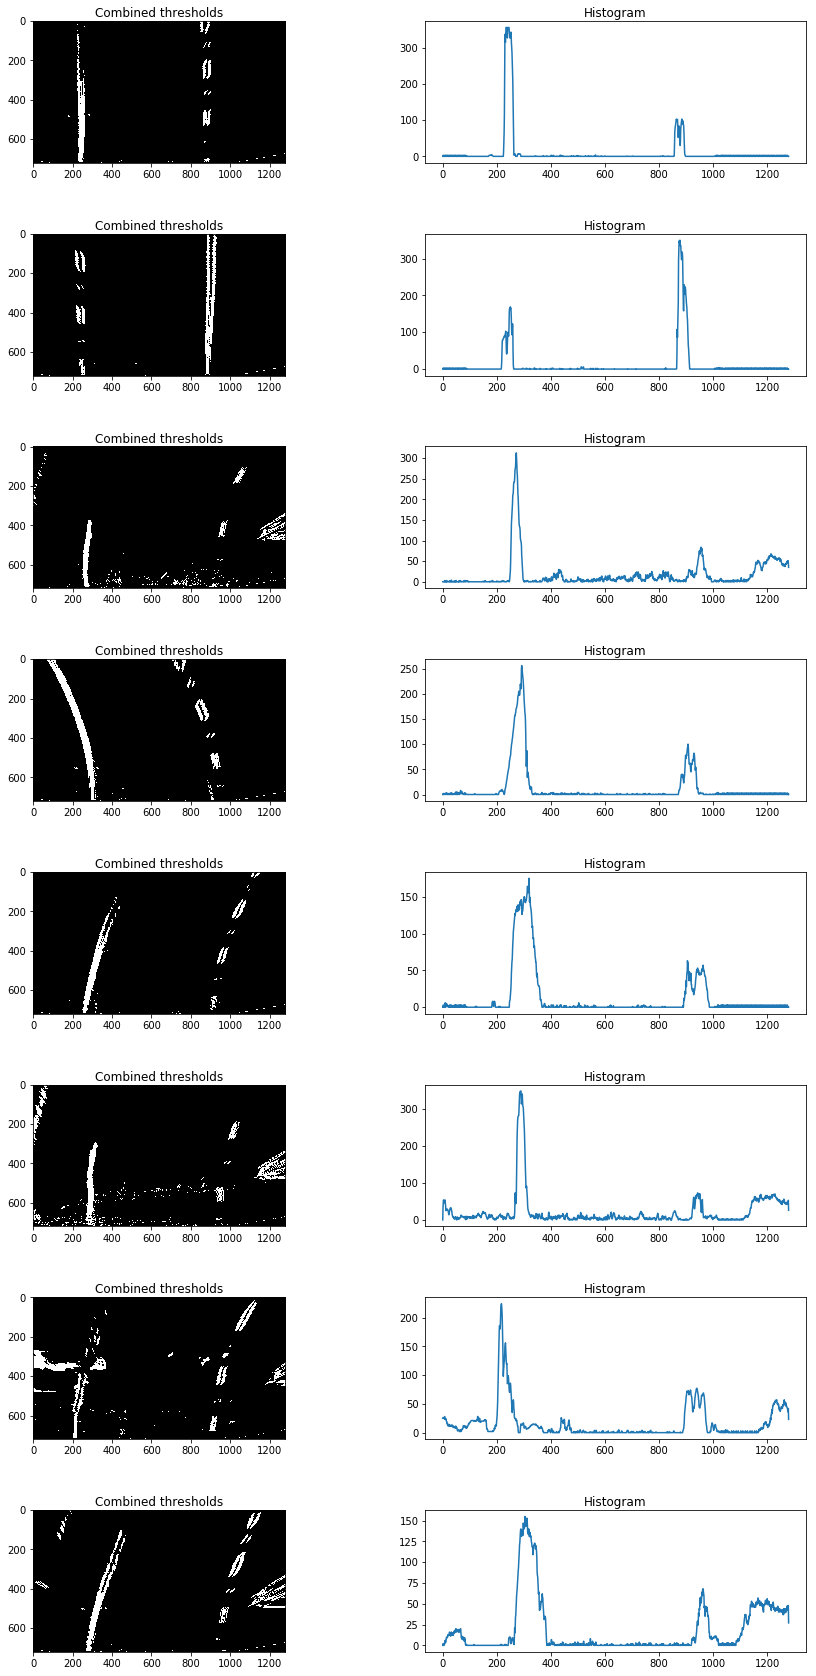

In [9]:
def hist(img):
    #  Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:, :]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histograms of image binary activations
histogram_action = lambda img:hist(img)
histograms = apply_filter(combined_binaries, histogram_action)

f, axes= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for i, img in enumerate(combined_binaries):
    axes[i, 0].set_title("Combined thresholds")
    axes[i, 0].imshow(combined_binaries[i], cmap='gray')
    
    axes[i, 1].set_title("Histogram")
    axes[i, 1].plot(histograms[i])

plt.show()

## Sliding window

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current  + margin  # Update this
        win_xright_low = rightx_current - margin   # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix :
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if  len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)
    return left_fit, right_fit, out_img

----->

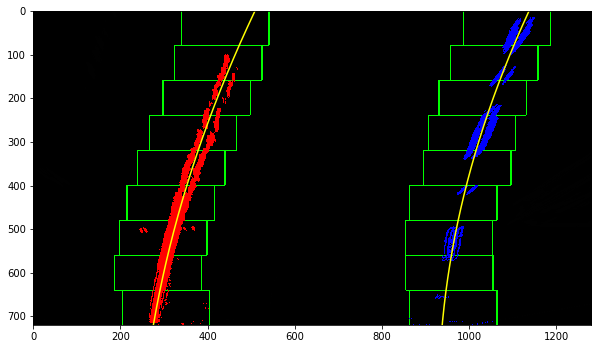

In [11]:
plt.subplots(figsize=(10,10))

# Check the output for one of the most fuzzy inputs
left_fit, right_fit,out_img = fit_polynomial(combined_binaries[7])

plt.imshow(out_img)

## Search from prior



In [16]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    global left_fit, right_fit
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    line_pts = np.hstack((left_line_window, right_line_window))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    cv2.polylines(window_img, np.int32([left_line_window]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(window_img, np.int32([right_line_window]), isClosed=False, color=(0,255,255), thickness=15)
    
    # Save fit for the next frame
    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result


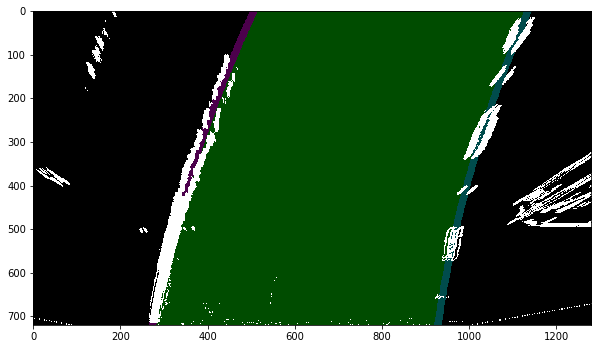

In [17]:
plt.subplots(figsize=(10,10))

# Run image through the pipeline
result = search_around_poly(combined_binaries[7])

plt.imshow(result)